### Image Colorization with OpenVino

This notebook demonstrates how to colorize images with OpenVINO using the Colorization model [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) based on the paper [Colorful Image Colorization](https://arxiv.org/abs/1603.08511).

![Let there be color](data/banner.png)


The idea here is given a grayscale image as input, the model hallucinates a plausible, vibrant & realistic colorized version of the image.

#### About Colorization-v2
* The colorization-v2 model is one of the colorization group of models designed to perform image colorization
* Model was trained on ImageNet dataset.
* Model consumes as input L-channel of LAB-image and give as output predict A- and B-channels of LAB-image.

## Imports

In [1]:
import cv2
import numpy as np
from typing import Dict, Tuple
import matplotlib.pyplot as plt
from openvino.runtime import Core

/home/art3mis/miniconda3/envs/openvino_env/lib/python3.7/site-packages/numpy/__init__.py:156: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


## Configurations

* `PRECISION` - {FP16, FP32}, default: FP16 
* `MODEL_DIR` - directory where the model is to be stored, default: public.
* `MODEL_NAME` - name of the model used for inference, default: colorization-v2
* `DATA_DIR` - directory where test images are stored, default: data
* `DEVICE` - {CPU, GPU, GNA,VPU} device to used for inference, default: CPU

In [2]:
PRECISION = "FP16"
MODEL_DIR="public"
MODEL_NAME="colorization-v2"
MODEL_PATH = f"{MODEL_DIR}/colorization-v2/{PRECISION}/{MODEL_NAME}.xml"
DATA_DIR = "data"
DEVICE="CPU"

## Download the model

`omz_downloader` downloads model files from online sources and, if necessary, patches them to make them more usable with Model Convertor.

In our case `omz_downloader` downloads the checkpoint and pytorch model of [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and saves it under `MODEL_DIR` as specified in above configuration

In [3]:
!omz_downloader --name colorization-v2

################|| Downloading colorization-v2 ||################

========== Downloading /mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/ckpt/colorization-v2-eccv16.pth
... 100%, 125953 KB, 7492 KB/s, 16 seconds passed

========== Downloading /mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/model/__init__.py
... 100%, 0 KB, 93 KB/s, 0 seconds passed

========== Downloading /mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/model/base_color.py
... 100%, 0 KB, 2083 KB/s, 0 seconds passed

========== Downloading /mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/model/eccv16.py
... 100%, 4 KB, 15317 KB/s, 0 seconds passed

========== Replacing text in /mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/model/__init__.py
========

## Convert the model to OpenVINO IR

`omz_converter` converts the models that are not in the OpenVINO™ IR format into that format using Model Optimizer.

Our downloaded pytorch model is not in OpenVINO IR format which is required for inference with OpenVINO runtime, `omz_converter` is used to convert our downloaded pytorch model into ONNX and OpenVINO IR format respectively

In [4]:
!omz_converter --name colorization-v2

========== Converting colorization-v2 to ONNX
Conversion to ONNX command: /home/art3mis/miniconda3/envs/openvino_env/bin/python -- /home/art3mis/miniconda3/envs/openvino_env/lib/python3.7/site-packages/openvino/model_zoo/internal_scripts/pytorch_to_onnx.py --model-path=/mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2 --model-name=ECCVGenerator --weights=/mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/ckpt/colorization-v2-eccv16.pth --import-module=model --input-shape=1,1,256,256 --output-file=/mnt/Backup/my_works/openvino_notebooks/notebooks/224-vision-image-colorization/public/colorization-v2/colorization-v2-eccv16.onnx --input-names=data_l --output-names=color_ab

/home/art3mis/miniconda3/envs/openvino_env/lib/python3.7/site-packages/numpy/__init__.py:156: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the b

## Loading the Model
Load the model in Inference Engine with `ie.read_model` and compile it for the specified device with `ie.compile_model`

In [5]:
ie = Core()
model = ie.read_model(model=MODEL_PATH)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
N, C, H, W = list(input_layer.shape)

## Utility Functions

In [6]:
def read_image(impath: str) -> np.ndarray:
    """
    Returns an image as ndarra, given path to an image reads the (BGR) image using opencv's
    imread() API.
    
        Parameter:
            impath (string): Path of the image to be read and returned.
        
        Returns:
            image (ndarray): Numpy array representing the read image.
    """
    
    raw_image = cv2.imread(impath)
    if raw_image.shape[2] > 1:
        image = cv2.cvtColor(cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image

def plot_image(image: np.ndarray, title: str="") -> None:
    """
    Given a image as ndarray and title as string, display it using 
    matplotlib.
    
        Parameters:
            image (ndarray): Numpy array representing the image to be displayed.
            title (string): String representing the title of the plot.
            
        Returns:
            None
            
    """
    
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
def plot_output(gray_img: np.ndarray, color_img: np.ndarray) -> None:
    """
    Plots the original (bw or grayscale) image and colorized image 
    on different column axes for comparing side by side.
    
        Parameters:
            gray_image (ndarray): Numpy array representing the original image.
            color_image (ndarray): Numpy array representing the model output.
            
        Returns:
            None
    """
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title('Input', fontsize=20)
    ax1.axis('off')
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.title('Colorized', fontsize=20)
    ax2.axis('off')
    
    ax1.imshow(gray_img)
    ax2.imshow(color_img)
    
    plt.show()

In [7]:
test_img_0 = read_image("data/test_0.jpg")
test_img_1 = read_image("data/test_1.jpg")

In [8]:
infer_request = compiled_model.create_infer_request()

In [9]:
def colorize(gray_img: np.ndarray, ir: object) -> np.ndarray:
    
    """
    Given an image as ndarray for inference with inference request
    convert the image into LAB image, the model consumes as input 
    L-Channel of LAB image and provides output A & B - Channels of 
    LAB image. i.e returns a colorized image
    
        Parameters:
            gray_img (ndarray): Numpy array representing the original image.
            ir (object): Inference request created from the compiled openVINO model.
            
        Returns:
            colorize_image (ndarray): Numpy arrray depicting the colorized version
                                      of the original image.
    """
    
    h_in, w_in, _ = gray_img.shape
    img_rgb = gray_img.astype(np.float32) / 255
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l_rs = cv2.resize(img_lab.copy(), (W, H))[:, :, 0]
    inputs = {}
    inputs['data_l'] = np.expand_dims(img_l_rs, axis=[0, 1])   
    res = infer_request.infer(inputs)[output_layer]
    update_res = np.squeeze(res)
    out = update_res.transpose((1, 2, 0))
    out = cv2.resize(out, (h_in, w_in))
    img_lab_out = np.concatenate((img_lab[:, :, 0][:, :, np.newaxis], out), axis=2)
    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2RGB), 0, 1)
    colorized_image = (cv2.resize(img_bgr_out, (h_in, w_in)) * 255).astype(np.uint8)
    return colorized_image

In [10]:
color_img_0 = colorize(test_img_0, infer_request)
color_img_1 = colorize(test_img_1, infer_request)

## Display Colorized Image

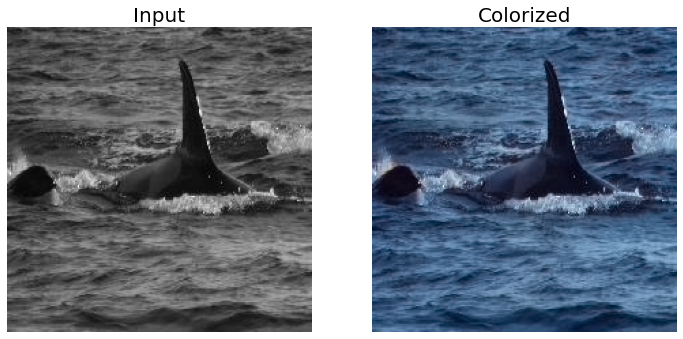

In [11]:
plot_output(test_img_0, color_img_0)

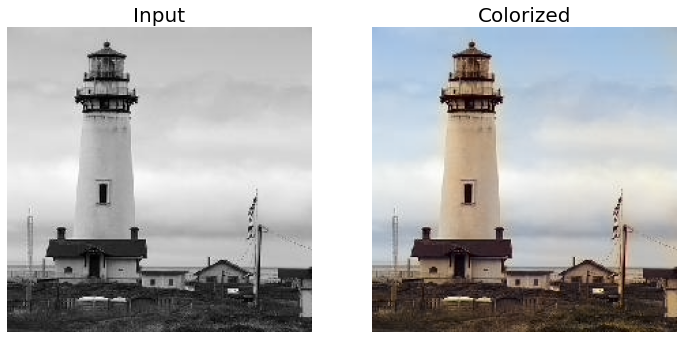

In [12]:
plot_output(test_img_1, color_img_1)